In [22]:
import numpy as np
from matplotlib import pyplot as plt
from math import sqrt
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score
from sklearn import svm
from scipy.io import savemat,loadmat
import warnings
warnings.filterwarnings("ignore")

In [12]:
import numpy as np
import random
import copy

''' 种群初始化函数 '''
def initial(pop, dim, ub, lb):
    X = np.zeros([pop, dim])
    for i in range(pop):
        for j in range(dim):
            X[i, j] = random.random()*(ub[j] - lb[j]) + lb[j]

    return X, lb, ub


'''边界检查函数'''


def BorderCheck(X, ub, lb, pop, dim):
    for i in range(pop):
        for j in range(dim):
            if X[i, j] > ub[j]:
                X[i, j] = ub[j]
            elif X[i, j] < lb[j]:
                X[i, j] = lb[j]
    return X


'''计算适应度函数'''


def CaculateFitness(X, fun):
    pop = X.shape[0]
    fitness = np.zeros([pop, 1])
    for i in range(pop):
        fitness[i] = fun(X[i, :])
    return fitness


'''适应度排序'''


def SortFitness(Fit):
    fitness = np.sort(Fit, axis=0)
    index = np.argsort(Fit, axis=0)
    return fitness, index


'''根据适应度对位置进行排序'''


def SortPosition(X, index):
    Xnew = np.zeros(X.shape)
    for i in range(X.shape[0]):
        Xnew[i, :] = X[index[i], :]
    return Xnew


'''引力搜索优化算法'''


def GSA(pop, dim, lb, ub, MaxIter, fun):
    # 参数设置
    X, lb, ub = initial(pop, dim, ub, lb)  # 初始化种群
    V, lb, ub = initial(pop, dim, ub, lb)  # 初始化速度
    fitness = CaculateFitness(X, fun)  # 计算适应度值
    minIndex = np.argmin(fitness)  # 寻找最小适应度值
    #  记录最优位置
    GbestScore = fitness[minIndex]
    GbestPositon = copy.copy(X[minIndex, :])
    Curve = np.zeros([MaxIter, 1])
    for t in range(MaxIter):
        print('第'+str(t)+'次迭代')
        # 计算M
        Fmax = np.max(fitness)
        Fmin = np.min(fitness)
        M = (fitness-Fmax)/(Fmin-Fmax)
        M = M/np.sum(M)
        # 计算引力系数
        alfa = 20
        G0 = 100
        G = G0*np.exp(-alfa*t/MaxIter)
        # 计算加速度
        ds = abs(np.argsort(-M, axis=0))
        E = np.zeros([pop, dim])
        kbest = int(2+(1-t/MaxIter)*(100-2))  # 选取一定量的个体，相互作用
        if kbest > pop:
            kbest = pop
        for i in range(pop):
            for j in range(kbest):
                k = ds[j]
                R = 0
                if k != i:
                    R = np.linalg.norm(X[i, :]-X[k, :])
                for a in range(dim):
                    E[i, a] = E[i, a]+np.random.random()*M[k] * \
                        (X[k, a]-X[i, a])/(R+10E-8)

        a = E*G
        # 速度和位置更新
        V = np.random.random([pop, dim])*V+a
        X = X+V
        X = BorderCheck(X, ub, lb, pop, dim)
        fitness = CaculateFitness(X, fun)  # 计算适应度值
        minIndex = np.argmin(fitness)  # 寻找最小适应度值
        if fitness[minIndex] < GbestScore:
            GbestScore = fitness[minIndex]
            GbestPositon = X[minIndex, :]

        Curve[t] = GbestScore

    return GbestScore, GbestPositon, Curve


In [3]:
# 转换成监督数据，将每个特征转换成21列数据，20->1，20组预测一组
def series_to_supervised(data, n_in=20, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]  #计算特征的数量
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    # 将20组输入数据依次向下移动20,19,...3,2,1行，将数据加入cols列表（技巧：(n_in, 0, -1)中的-1指倒序循环，步长为1）
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    # 将一组输出数据加入cols列表（技巧：其中i=0）
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # cols列表(list)中现在有21块经过下移后的数据(即：df(-20),df(-19),...df(-2),df(-1),df)，将四块数据按列 并排合并
    agg = pd.concat(cols, axis=1)
    # 给合并后的数据添加列名
    agg.columns = names
    # print(agg)
    # 删除NaN值列
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [4]:
dataset = pd.read_excel("816480.xlsx")
fratures_Corrected_irradiance = [
    'Flow (Veh/5 Minutes)'
]
values = dataset[fratures_Corrected_irradiance].values
n_features=1 #特征数量

In [5]:
# 标准化
scaler =StandardScaler()
scaled = scaler.fit_transform(values)

In [6]:
n_in = 3
n_out = 1
# 构造一个20->1的监督学习型数据
reframed = series_to_supervised(scaled, n_in=n_in, n_out=n_out)
values=reframed.values

In [7]:
#训练集和测试集的划分比例
ratio=0.8 
N=int(len(values) *ratio)
train = values[:N, :]
test = values[N:, :]

# 划分输入和输出,split into input and outputs
n_obs = n_in *  n_features
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
train_y=train_y.reshape(-1,1)
test_y=test_y.reshape(-1,1)

(1149, 3) (1149,) (288, 3) (288,)


In [8]:
'''目标函数(适应度函数)'''
#定义适应函数，以测试集和训练集的绝对误差和为适应度值
def fun(X):
  #3.训练svR
    Model=svm.SVR(C=X[0],kernel='rbf',gamma=X[1]) # ovr:一对多策略
    Model.fit(train_X,train_y)#ravel函数在降维时默认是行序优先
    #4.计算svc预测绝对误差
    PredictTrain=Model.predict(train_X) #训练集的预测
    PredictTest=Model.predict(test_X) #测试集的预测
    MSETrainWOA= np.sqrt(np.sum((PredictTrain - train_y[:,0])**2))/train_y.size #计算MSE
    MSETestWOA=np.sqrt(np.sum((PredictTest- test_y[:,0])**2))/test_y.size#计算MSE
    output = MSETrainWOA+MSETestWOA
    return output

In [13]:
#设置参数
pop = 20 #种群数量
MaxIter = 50 #最大迭代次数
dim = 2 #维度
lb = np.array([0.1,0.1]) #下边界
ub = np.array([20,20])#上边界
fobj = fun
GbestScore,GbestPositon,Curve = GSA(pop,dim,lb,ub,MaxIter,fobj)
print('最优适应度值：',GbestScore)
print('c,g最优解：',GbestPositon)

第0次迭代
第1次迭代
第2次迭代
第3次迭代
第4次迭代
第5次迭代
第6次迭代
第7次迭代
第8次迭代
第9次迭代
第10次迭代
第11次迭代
第12次迭代
第13次迭代
第14次迭代
第15次迭代
第16次迭代
第17次迭代
第18次迭代
第19次迭代
第20次迭代
第21次迭代
第22次迭代
第23次迭代
第24次迭代
第25次迭代
第26次迭代
第27次迭代
第28次迭代
第29次迭代
第30次迭代
第31次迭代
第32次迭代
第33次迭代
第34次迭代
第35次迭代
第36次迭代
第37次迭代
第38次迭代
第39次迭代
第40次迭代
第41次迭代
第42次迭代
第43次迭代
第44次迭代
第45次迭代
第46次迭代
第47次迭代
第48次迭代
第49次迭代
最优适应度值： [0.01756995]
c,g最优解： [9.79871549 1.32600551]


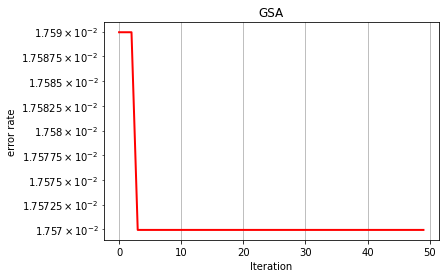

In [14]:
#绘制适应度曲线
plt.figure(1)
plt.semilogy(Curve,'r-',linewidth=2)
plt.xlabel('Iteration',fontsize='medium')
plt.ylabel("error rate",fontsize='medium')
plt.grid()
plt.title('GSA',fontsize='large')
plt.show()

In [17]:
#利用最优权值阈值进行训练
Model=svm.SVR(C=GbestPositon[0,0],kernel='rbf',gamma=GbestPositon[0,1])
Model.fit(train_X,train_y)

SVR(C=9.798715492776381, gamma=1.3260055067220917)

In [18]:
# 作出预测
yhat = Model.predict(test_X)
yhat=yhat.reshape(-1,1)
yhat = np.repeat(yhat,n_in*n_features+n_out, axis=-1)
inv_yhat=scaler.inverse_transform(np.reshape(yhat,(len(yhat),n_in*n_features+n_out)))[:,0]
test_y=test_y.reshape(-1,1)
y = np.repeat(test_y,n_in*n_features+n_out, axis=-1)
inv_y=scaler.inverse_transform(np.reshape(y,(len(test_y),n_in*n_features+n_out)))[:,0]

In [19]:
# 计算RMSE
def mape(y_true, y_pred):
    #评价指标MAPE
    record=[]
    for index in range(len(y_true)):
        if abs(y_true[index])>10:
            temp_mape=np.abs((y_pred[index] - y_true[index]) / y_true[index])
            record.append(temp_mape)
    return np.mean(record) * 100
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.7f' % rmse)
print('Test MAE: %.7f' % mean_absolute_error(inv_y, inv_yhat))
print('Test MAPE: %.7f' % mape(inv_y, inv_yhat))
print('Test R2: %.7f' % r2_score(inv_y, inv_yhat))

Test RMSE: 34.2210327
Test MAE: 26.2832489
Test MAPE: 9.0264309
Test R2: 0.9560292


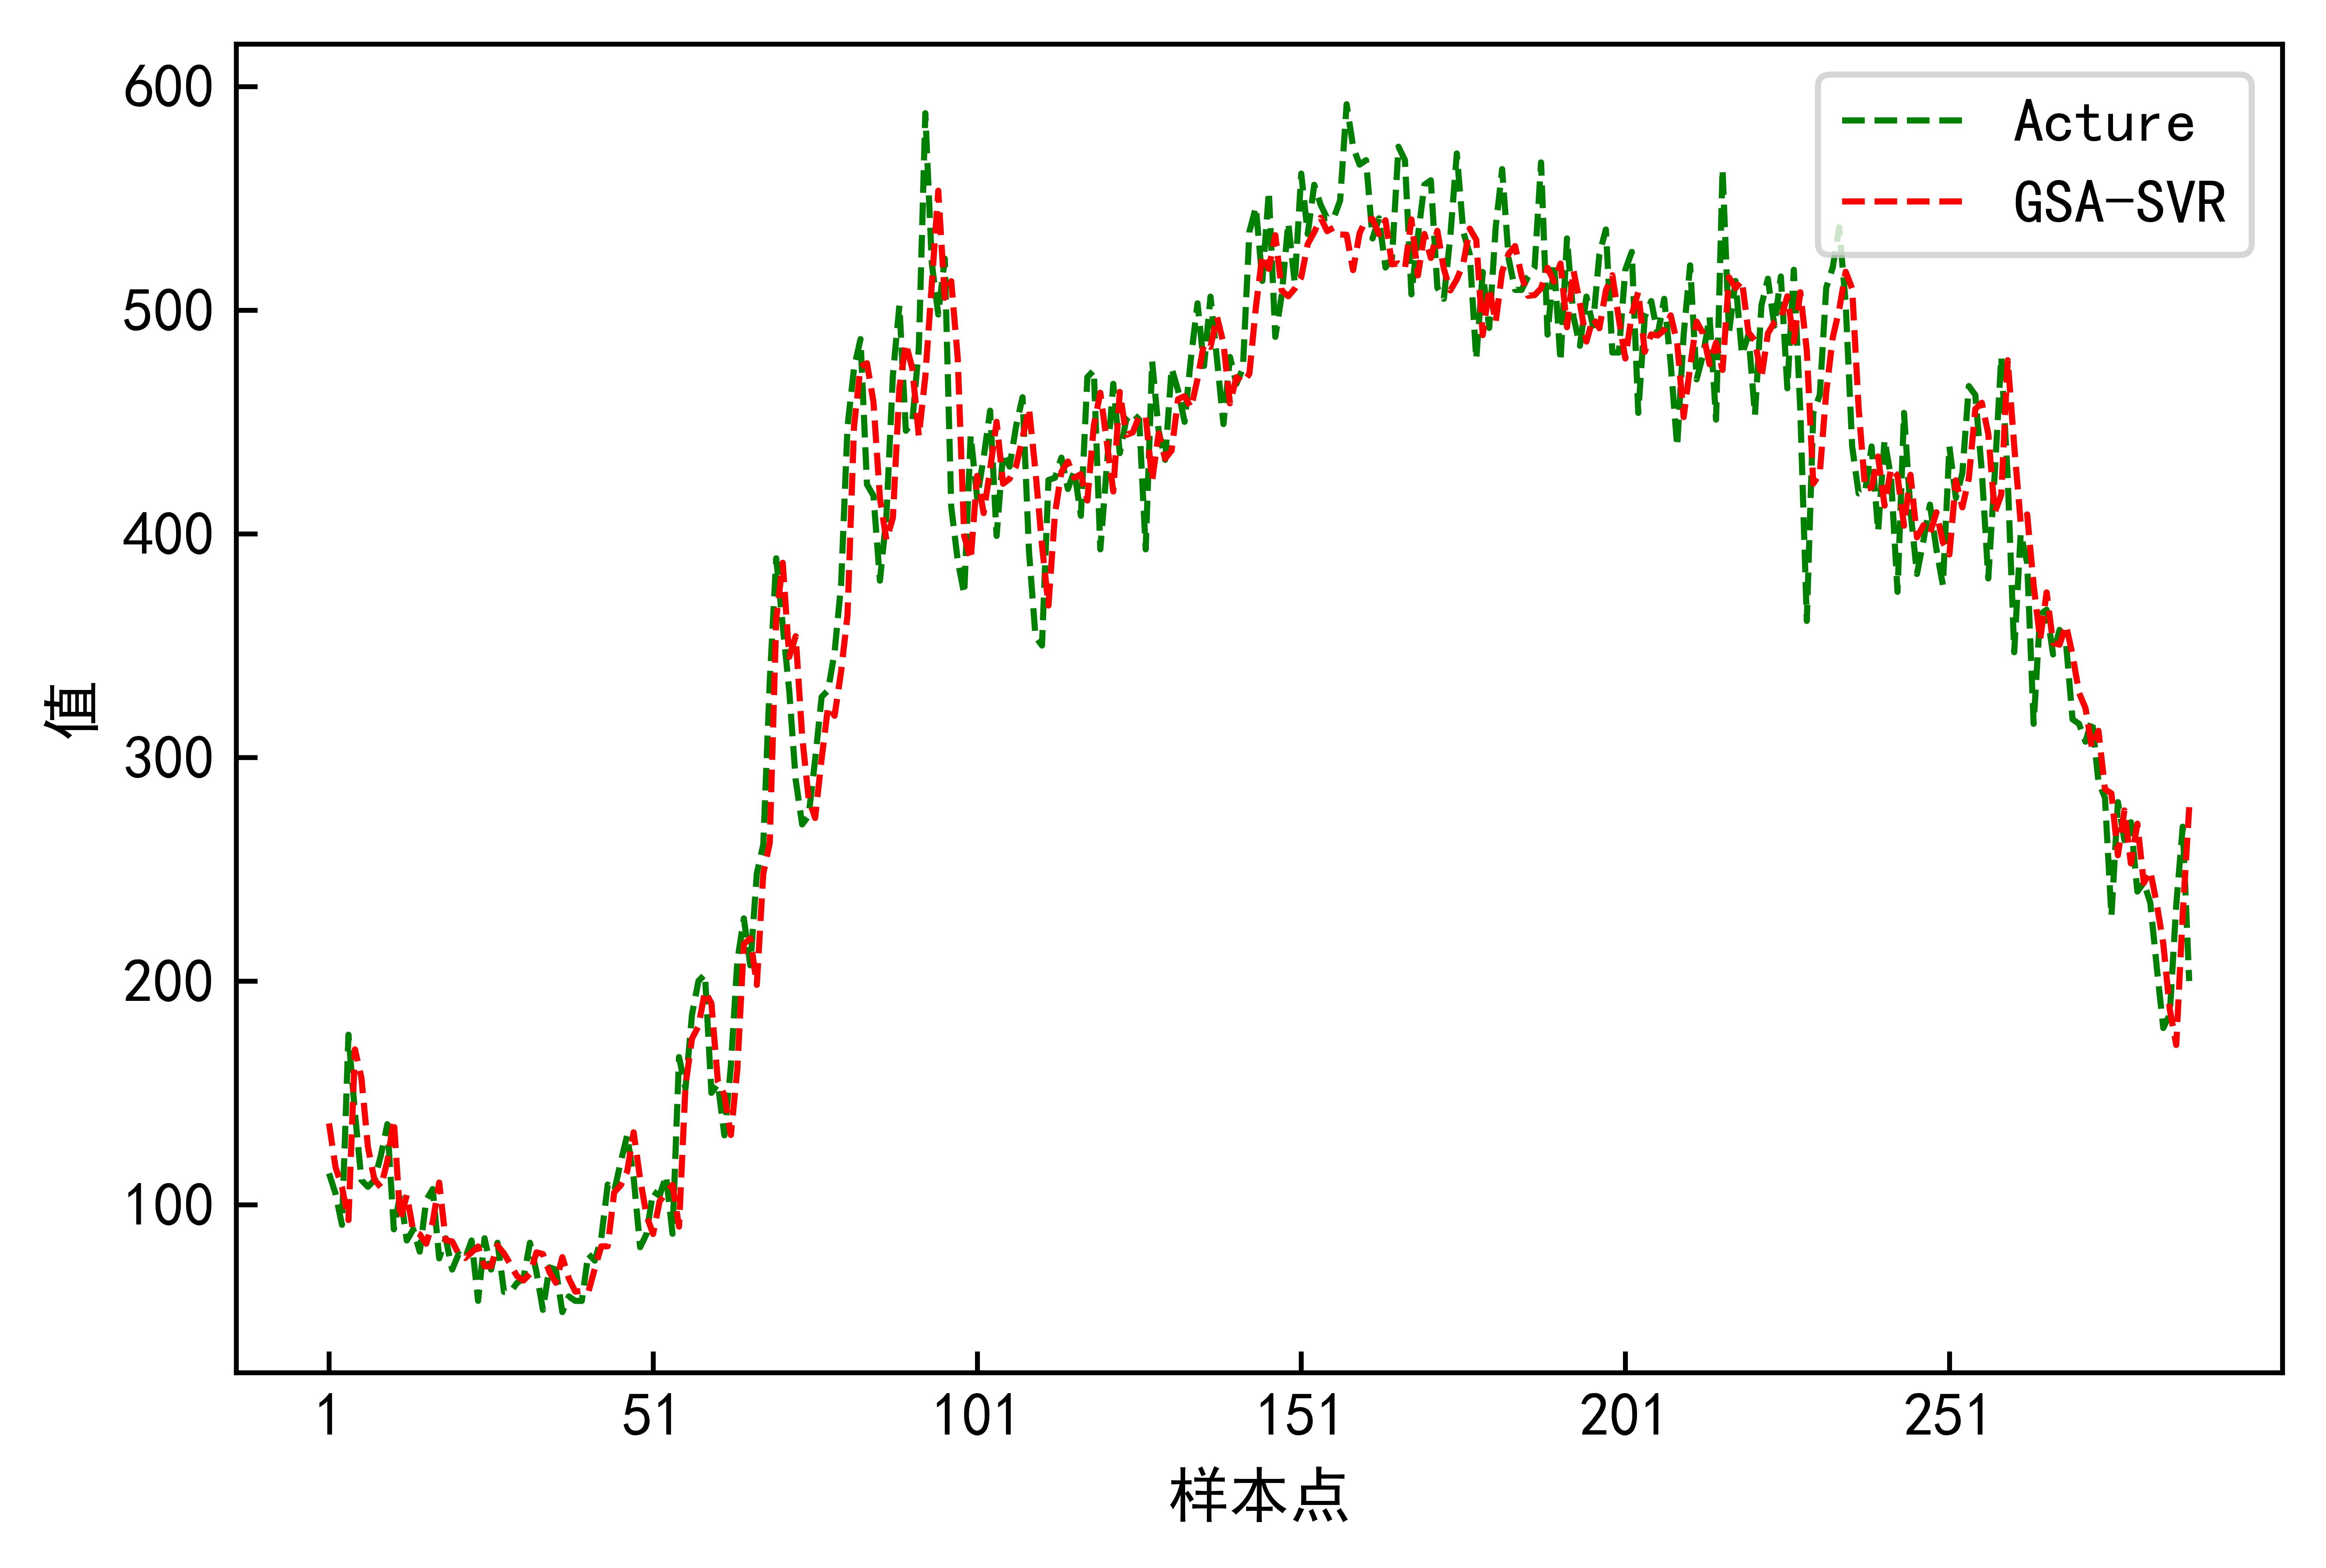

In [20]:
import seaborn as sns
%config InlineBackend.figure_format = 'retina'
plt.rcParams['font.sans-serif']=['Simhei']  #解决画图中文不显示问题
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.figure(figsize=(6,4),dpi=600)
x=range(1, len(inv_yhat)+1)
plt.xticks(x[::50])
plt.tick_params(labelsize=10)  #改变刻度字体大小
plt.plot(x, inv_y, linestyle="--",color='g',linewidth=1, label='Acture')
plt.plot(x, inv_yhat, color='red',linestyle="--",linewidth=1,label='GSA-SVR')
# plt.plot(x, inv_y,color='g',linewidth=1, label='真实值')
# plt.plot(x, inv_yhat,color='red',linestyle="--",linewidth=1,label='预测值')
plt.rcParams.update({'font.size': 10})  #改变图例里面的字体大小
plt.legend(loc='upper right')
plt.xlabel("样本点",fontsize=10)
plt.ylabel("值",fontsize=10)
# plt.xlim(xmin=600,xmax=700)  #显示600-1000的值   局部放大有利于观察
# plt.savefig('figure/LSTM预测结果图.png')
plt.show()

In [23]:
#保存预测结果
savemat('结果/gsa_svr_result.mat',{'true':inv_y,'pred':inv_yhat})